# Project Sunset
2020년 과학 탐구 보고서 발표 대회에 사용될 코드입니다.

-----------------------------------------------------------------------------------------

Double Check Process의 효과를 검증하기 위한 코드입니다.

### (1) 필요 라이브러리 및 프레임워크 임포트 & 사용 디바이스 선택(CPU or GPU)

In [39]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import random
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import json

from tqdm import tqdm, tqdm_notebook

from PIL import Image

from IPython.display import clear_output

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

### (2) 하이퍼 파라미터 선언

In [ ]:
prepath = "E:/Dataset/ImageNet/Val/ILSVRC2012_img_val"

### (3) 데이터셋 로드

In [3]:
file_list = os.listdir(prepath)
file_list_jpg = [file for file in file_list if file.endswith(".JPEG")]

In [40]:
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]

In [4]:
def imshow(img_tensor):
    original_img_view = img_tensor.squeeze(0).detach()
    original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()

    plt.imshow(original_img_view)

In [5]:
def loadTensorImage(path):
    img = Image.open(path)
    img_transforms = transforms.Compose([
        transforms.Resize((224, 224), Image.BICUBIC),
        transforms.ToTensor(),
    ])

    img_tensor = img_transforms(img)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

### (4) MainModel로 사용할 ResNet과 SubModel로 사용할 VGGNet 로드

In [6]:
MainModel = models.resnet101(pretrained=True)
SubModel = models.vgg19_bn(pretrained=True)

MainModel.eval()
SubModel.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### (5) FGSM 어택 함수 선언

In [7]:
def fgsm_attack(image, epsilon, gradient):
    # 기울기값의 원소의 sign 값을 구함
    sign_gradient = gradient.sign()
    # 이미지 각 픽셀의 값을 sign_gradient 방향으로 epsilon 만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    # [0,1] 범위를 벗어나는 값을 조절
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [8]:
def getPertubedImage(img_tensor, target, epsilon, model):
    model.eval()
    img_tensor.requires_grad_(True)
    output = model(img_tensor)
    loss = F.nll_loss(output, target) 
    
    model.zero_grad()
    loss.backward()
    
    gradient = img_tensor.grad.data
    
    perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)
    return perturbed_data#.squeeze(0)

### (6) Double Check Process 함수 선언

In [52]:
def doubleCheckProcess(img, mainModel, subModel, debug=False):
    global idx2class
    img = img.to(DEVICE)
    
    mainModelAnswer = mainModel(img).max(1, keepdim=True)[1]
    subModelAnswer = subModel(img).max(1, keepdim=True)[1]
    
    if debug :
        print("메인 모델(ResNet)의 답안 : {0}".format(idx2class[mainModelAnswer.item()]))
        print("서브 모델(VGGNet)의 답안 : {0}".format(idx2class[subModelAnswer.item()]))
    
    if mainModelAnswer==subModelAnswer:
        return mainModelAnswer
    else :
        return -1

### (7) 정상 이미지 테스트

메인 모델(ResNet)의 답안 : Pembroke, Pembroke Welsh corgi
서브 모델(VGGNet)의 답안 : Pembroke, Pembroke Welsh corgi
---------------------------------------------------------------------------------------------
FGSM 공격용 이미지가 아닙니다. [예상 답변 : Pembroke, Pembroke Welsh corgi]


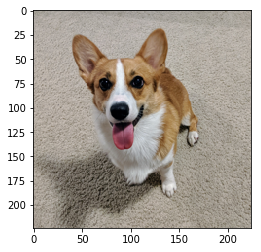

In [53]:
img_tensor = loadTensorImage('E:\Dataset\ImageNet\Val\corgie.jpg')
imshow(img_tensor)

ans = doubleCheckProcess(img_tensor, MainModel, SubModel, debug=True)
print("---------------------------------------------------------------------------------------------")
if ans == -1 :
    print("FGSM 공격용 이미지입니다.")
else :
    print("FGSM 공격용 이미지가 아닙니다. [예상 답변 : {0}]".format(idx2class[ans.item()]))

### (8) FGSM 공격용 이미지 테스트

메인 모델(ResNet)의 답안 : dingo, warrigal, warragal, Canis dingo
서브 모델(VGGNet)의 답안 : Pembroke, Pembroke Welsh corgi
---------------------------------------------------------------------------------------------
FGSM 공격용 이미지입니다.


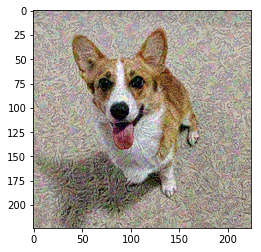

In [54]:
img_tensor = loadTensorImage('E:\Dataset\ImageNet\Val\corgie.jpg')
img_tensor = getPertubedImage(img_tensor, torch.tensor([263]), 0.07, MainModel)

original_img_view = img_tensor.squeeze(0).detach()
original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()*255
original_img_view = Image.fromarray(original_img_view.astype('uint8')).convert('RGB')

img_transforms = transforms.Compose([
                transforms.Resize((224, 224), Image.BICUBIC),
                transforms.ToTensor(),
            ])

img_tensor = img_transforms(original_img_view)
img_tensor = img_tensor.unsqueeze(0)

imshow(img_tensor)
ans = doubleCheckProcess(img_tensor, MainModel, SubModel, debug=True)
print("---------------------------------------------------------------------------------------------")
if ans == -1 :
    print("FGSM 공격용 이미지입니다.")
else :
    print("FGSM 공격용 이미지가 아닙니다. [예상 답변 : {0}]".format(idx2class[ans.item()]))

### (9) 감지 성공률 계산

In [16]:
correct = 0
num = 0
random.shuffle(file_list_jpg)
bar_total=tqdm_notebook(file_list_jpg)
for i in bar_total:
    bar_total.set_description("구분 성공 : {0}/{1}".format(correct, num))
    imgurl = prepath + "/" + i
    r = random.randrange(0, 2)
    
    try:
        img_tensor = loadTensorImage(imgurl)
    except:
        continue
    if r==0 :
        try:
            boolean = doubleCheckProcess(img_tensor, MainModel, SubModel)
        except:
            continue
        if boolean :
            correct += 1
    else :
        try:
            img_tensor = getPertubedImage(img_tensor, MainModel(img_tensor).max(1, keepdim=True)[1].squeeze(0), 0.07, MainModel)
        except:
            continue
            
        try:    
            img_tensor = loadTensorImage(imgurl)
            img_tensor = getPertubedImage(img_tensor, torch.tensor([263]), 0.07, MainModel)

            original_img_view = img_tensor.squeeze(0).detach()
            original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()*255
            original_img_view = Image.fromarray(original_img_view.astype('uint8')).convert('RGB')
            
            img_transforms = transforms.Compose([
                transforms.Resize((224, 224), Image.BICUBIC),
                transforms.ToTensor(),
            ])

            img_tensor = img_transforms(original_img_view)
            img_tensor = img_tensor.unsqueeze(0)

            boolean = doubleCheckProcess(img_tensor, MainModel, SubModel)
        except:
            continue
        if not boolean :
            correct += 1
    num += 1   
    if num >= 10001 :
        break
print("구분 성공률 : {0}%".format(correct*100/num))

C:\Users\LHZ\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


구분 성공률 : 64.85351464853515%
